<a href="https://colab.research.google.com/github/Dimonfordont/DS_course/blob/main/Basics/Models/Bank_AB_response_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank marketing campaign response using Classifiers and encoders

In [ ]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

--2023-04-21 17:24:48--  http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip.2’

bank.zip.2          100%[===================>] 565.47K  1.64MB/s    in 0.3s    

2023-04-21 17:24:49 (1.64 MB/s) - ‘bank.zip.2’ saved [579043/579043]



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score,f1_score, recall_score,precision_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn import svm
from scipy import stats
from zipfile import ZipFile

In [ ]:
with ZipFile("bank.zip", 'r') as zip:
    zip.extractall()

df = pd.read_csv("bank.csv", sep = ';')

#EDA

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [ ]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


#Convert 64 to 32 and object to category

In [ ]:
def improve_cats(df):
  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = df[col].astype('category')
    elif df[col].dtype == 'int64':
      df[col] = df[col].astype('int32')
  return df

In [ ]:
df1 = improve_cats(df)

##Check for NaNs

In [ ]:
for col in df.columns:
  print(f'{col}: {df1[col].isna().sum()}')

age: 0
job: 0
marital: 0
education: 0
default: 0
balance: 0
housing: 0
loan: 0
contact: 0
day: 0
month: 0
duration: 0
campaign: 0
pdays: 0
previous: 0
poutcome: 0
y: 0


##Check duplicates

In [ ]:
print(f"Num of duplicates: {df1.duplicated().sum()}")

Num of duplicates: 0


##Create dataset and target

In [ ]:
X = df1.drop(columns = ['y']).copy()
target = df1['y'].copy()

#Encode by binarizing data

In [ ]:
target = LabelBinarizer().fit_transform(target).ravel()

In [ ]:
pd.Series(target).describe()

count    4521.000000
mean        0.115240
std         0.319347
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64

Looks like data is unbalanced

<Axes: >

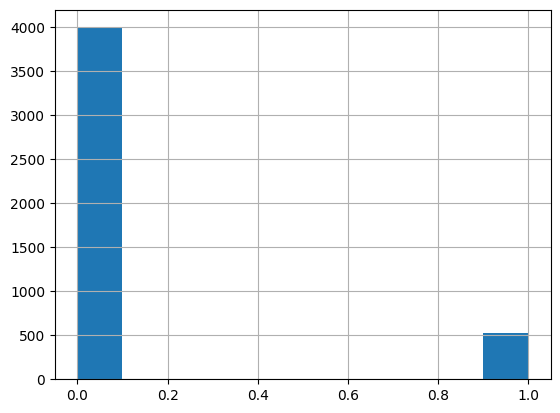

In [ ]:
pd.Series(target).hist()

## Encode the resot of the data using OHE   

In [ ]:
for col in [n for n in X.columns if X[n].dtype in ['category', 'object']]:
  print(col, X[col].unique())
  print()

job ['unemployed', 'services', 'management', 'blue-collar', 'self-employed', ..., 'admin.', 'student', 'housemaid', 'retired', 'unknown']
Length: 12
Categories (12, object): ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', ..., 'student',
                          'technician', 'unemployed', 'unknown']

marital ['married', 'single', 'divorced']
Categories (3, object): ['divorced', 'married', 'single']

education ['primary', 'secondary', 'tertiary', 'unknown']
Categories (4, object): ['primary', 'secondary', 'tertiary', 'unknown']

default ['no', 'yes']
Categories (2, object): ['no', 'yes']

housing ['no', 'yes']
Categories (2, object): ['no', 'yes']

loan ['no', 'yes']
Categories (2, object): ['no', 'yes']

contact ['cellular', 'unknown', 'telephone']
Categories (3, object): ['cellular', 'telephone', 'unknown']

month ['oct', 'may', 'apr', 'jun', 'feb', ..., 'jul', 'nov', 'sep', 'mar', 'dec']
Length: 12
Categories (12, object): ['apr', 'aug', 'dec', 'feb', ..., 'may', 'nov', 'oct

Let's map values for months

In [ ]:
mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
X['month'] = X['month'].map(mapping).astype('int32')
X['month']

0       10
1        5
2        4
3        6
4        5
        ..
4516     7
4517     5
4518     8
4519     2
4520     4
Name: month, Length: 4521, dtype: int32

###Binarize X binary vals

In [ ]:
for col in ['default', 'loan', 'housing']:
  X[col] = LabelBinarizer().fit_transform(X[col])

In [ ]:
[x for x in X.columns if X[x].dtype in ['category', 'object']]

['job', 'marital', 'education', 'contact', 'poutcome']

In [ ]:
X['job'] = LabelEncoder().fit_transform(X['job']).astype('int32')

In [ ]:
X = pd.get_dummies(X)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  4521 non-null   int32
 1   job                  4521 non-null   int32
 2   default              4521 non-null   int64
 3   balance              4521 non-null   int32
 4   housing              4521 non-null   int64
 5   loan                 4521 non-null   int64
 6   day                  4521 non-null   int32
 7   month                4521 non-null   int32
 8   duration             4521 non-null   int32
 9   campaign             4521 non-null   int32
 10  pdays                4521 non-null   int32
 11  previous             4521 non-null   int32
 12  marital_divorced     4521 non-null   uint8
 13  marital_married      4521 non-null   uint8
 14  marital_single       4521 non-null   uint8
 15  education_primary    4521 non-null   uint8
 16  education_secondary  452

#Split model

In [ ]:
def print_score(y, y_pred, name = 'Train'):
  print(name+' accuracy: ', accuracy_score(y, y_pred > 0.2))
  print(name+' precision: ', precision_score(y, y_pred > 0.2))
  print(name+' recall: ', recall_score(y, y_pred > 0.2))
  print(name+' F measure: ', f1_score(y, y_pred > 0.2))
  print(name+' ROC-AUC: ', roc_auc_score(y, y_pred))
  print()

In [ ]:
def prepare_data(df):
  df = improve_cats(df).copy()
  df['y'] = LabelBinarizer().fit_transform(df['y'])

  mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
  df['month'] = df['month'].map(mapping).astype('int32')

  for col in ['default', 'loan', 'housing']:
    df[col] = LabelBinarizer().fit_transform(df[col])

  df['job'] = LabelEncoder().fit_transform(df['job']).astype('int32')
  df = pd.get_dummies(df)
  return train_test_split(df.drop(columns=['y']), df['y'], test_size=0.2, stratify = df['y'], random_state=42)

#Run model and predict values

In [ ]:
def run_test_model(model, df):
  X_train, X_test, y_train, y_test = prepare_data(df)
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  print_score(y_train, y_pred_train)
  y_pred_test = model.predict(X_test)
  print_score(y_test, y_pred_test, 'Test')

In [ ]:
models = [LinearRegression(), RidgeClassifier(), KNeighborsClassifier(n_neighbors=4), svm.SVC(class_weight='balanced'), GaussianNB()]
names = ['linear', 'Ridge', 'KNN', 'SVM', 'Naive Bayes']
for n in range(len(models)):
  print(names[n])
  run_test_model(models[n], df)
  print()

linear
Train accuracy:  0.8537057522123894
Train precision:  0.4161676646706587
Train recall:  0.6666666666666666
Train F measure:  0.5124423963133641
Train ROC-AUC:  0.8828403360462614

Test accuracy:  0.8486187845303867
Test precision:  0.40350877192982454
Test recall:  0.6634615384615384
Test F measure:  0.5018181818181818
Test ROC-AUC:  0.867893498511476


Ridge
Train accuracy:  0.8979535398230089
Train precision:  0.65
Train recall:  0.24940047961630696
Train F measure:  0.36048526863084923
Train ROC-AUC:  0.6159475045783942

Test accuracy:  0.8950276243093923
Test precision:  0.6
Test recall:  0.25961538461538464
Test F measure:  0.3624161073825503
Test ROC-AUC:  0.6185717372515125


KNN
Train accuracy:  0.9068030973451328
Train precision:  0.8076923076923077
Train recall:  0.2517985611510791
Train F measure:  0.38391224862888484
Train ROC-AUC:  0.6219918094908256

Test accuracy:  0.8828729281767956
Test precision:  0.46875
Test recall:  0.14423076923076922
Test F measure:  0.220

So we have encoded the data with different encoder and run different models.
We can see low precision, recall and (makes sense) F score.
Since data is unbalanced (even though we tried to stratify) we got lots of False positives (precision is the lowest). Low recall means models weren't able to detect many true positive cases. For F measure Linear regression performed the best.
